In [12]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import confusion_matrix, f1_score, RocCurveDisplay

from catboost import CatBoostClassifier, Pool
import optuna
from IPython.display import display

In [13]:
# Load the dataset
df = pd.read_csv(r"D:\tesis_u_sabana\data\results\contracts_colombia_test.csv", sep="~", encoding='utf-8')
df.drop(columns=[
    'id_contrato', 'documento_proveedor','nit_entidad_x','va_2022_a1', 'fecha_de_inicio_del_contrato',
    'fecha_de_fin_del_contrato','va_2022_a2', 'va_2022_a3', 'va_2022', 'va_%_d_2022','valor_facturado',
    'valor_pendiente_de_pago','valor_de_pago_adelantado','valor_pendiente_de_ejecucion','codigo_proveedor',
    'id_del_proceso', 'id_del_portafolio','dominant_topic_y','valor_del_contrato_y','codigo','departamento_y', 'latitud',
    'longitud', 'codigo_capital', 'capital','estado_contrato'
], inplace=True)
df.drop(df.index[0], inplace=True)
scaler = MinMaxScaler()
df[['poblacion_m']] = scaler.fit_transform(df[['poblacion_m']])
df[['%_nbi']] = scaler.fit_transform(df[['%_nbi']])
df[['d_a_capital']] = scaler.fit_transform(df[['d_a_capital']])

In [14]:

# Prepare X and y
y = df['tipo_de_modificacion']
X = df.drop(columns=['tipo_de_modificacion'])
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
X = X.copy()
X[categorical_features] = X[categorical_features].fillna("missing").astype('category')
X["dominant_topic_x"] = X["dominant_topic_x"].astype("category")
categorical_features.append("dominant_topic_x")


In [15]:
# MCCV evaluation function
def mccv_evaluation(learner, X, y, repeats=10, train_size=0.7, pipeline_name=None, categorical_features=None):
    print("Performing Monte Carlo Cross Validation for Evaluation")
    print(f"Repeats: {repeats}")
    label_order = np.unique(y)
    conf_matrix_sum = None
    f_score_sum = 0.000001
    all_y_true = []
    all_y_prob = []
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'MCCV Evaluation - {pipeline_name}')
    color_map = {
        "sin_cambios": "green",
        "modificacion_riesgosa": "red",
        "modificacion_general": "gold"
    }
    for i in range(repeats):
        
        y_pred = learner.predict(X)
        cm = confusion_matrix(y, y_pred, labels=label_order)
        conf_matrix_sum = cm if conf_matrix_sum is None else conf_matrix_sum + cm
        f_score = f1_score(y, y_pred, average="weighted", labels=label_order)
        f_score_sum += f_score
        print(f"Iteration {i+1}/{repeats} - F1 Score: {f_score:.4f}")
        try:
            y_prob = learner.predict_proba(X)
            all_y_true.extend(y)
            all_y_prob.extend(y_prob)
        except AttributeError:
            print("Warning: predict_proba not available.")
    print(f"Average F1 Score: {f_score_sum / repeats:.4f}")
    avg_conf_matrix = conf_matrix_sum / repeats
    avg_confusion_df = pd.DataFrame(avg_conf_matrix, index=label_order, columns=label_order)
    sns.heatmap(avg_confusion_df, annot=True, cmap="Blues", fmt=".2f", cbar=True, ax=ax1)
    ax1.set_title("Average Confusion Matrix")
    try:
        all_y_true_bin = label_binarize(all_y_true, classes=label_order)
        all_y_prob = np.array(all_y_prob)
        for j, class_label in enumerate(label_order):
            RocCurveDisplay.from_predictions(all_y_true_bin[:, j], all_y_prob[:, j], ax=ax2, name=f"Class {class_label}", color=color_map.get(class_label, "gray"))
    except Exception as e:
        print(f"Could not plot ROC: {e}")
    ax2.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
    ax2.set_title('Multi-class ROC Curve')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return avg_confusion_df


In [16]:
import joblib

# Load the model
model = joblib.load(r'D:\tesis_u_sabana\notebooks\hiperparametros_cb.ipynb\model_final.pkl')



Performing Monte Carlo Cross Validation for Evaluation
Repeats: 1
Iteration 1/1 - F1 Score: 0.8158
Average F1 Score: 0.8158


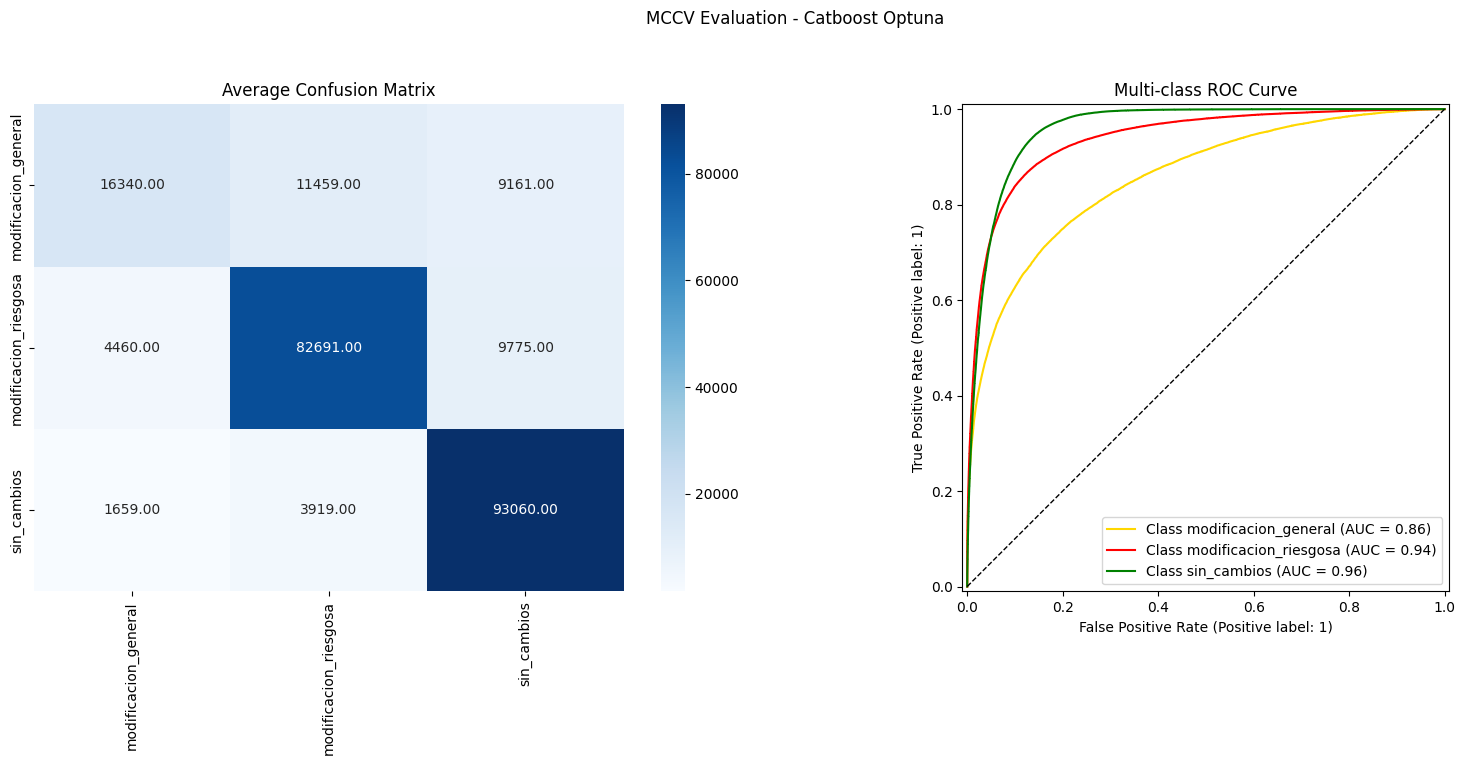

In [17]:
# Final MCCV evaluation
avg_conf_matrix = mccv_evaluation(model, X, y, repeats=1, train_size=1, pipeline_name="Catboost Optuna", categorical_features=categorical_features)
